# <b> <center> <font color='#7B241C'> CLASS ACTIVATION MAP </font> </center> </b>

## <font color='blue'> Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Load a pre-trained model and an example image](#3)
4. [Compute CAM and visualization](#4)
5. [References](#references)

<a name="1"></a>
## <b> <font color='red'> 1. Introduction </font> </b>

This notebook demonstrates how to generate and visualize Class Activation Maps (CAMs) for convolutional neural networks. CAMs help us understand which regions of an input image contribute most to a model's classification decision. This is a powerful tool for model interpretability, especially in tasks like image classification, object detection, and medical imaging.

We’ll walk through the process using a pretrained CNN, highlighting the areas in the image that activate most strongly for a specific class prediction.

<a name="2"></a>
## <b> <font color='red'> 2. Setup </font> </b>

In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

<a name="3"></a>
## <b> <font color='red'> 3. Load a pre-trained model and an example image </font> </b>

As model, we will use Resnet18.

ResNet18 is a 18-layer deep convolutional neural network from the Residual Networks family. It's designed to train very deep networks effectively by using residual (skip) connections that help mitigate the vanishing gradient problem.

Key points:

- Contains 18 layers with learnable weights.

- Trained on ImageNet (1000 classes) when using pretrained=True.

- Input size: 3×224×224 RGB images.

In [4]:
model = models.resnet18(pretrained=True).eval()

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

You can see that ResNet-18 consists of the following main components:

Input → Conv1 → BN → ReLU → MaxPool →

    layer1 →
    
    layer2 →
    
    layer3 →
    
    layer4 →
    
    AvgPool → FC (Fully Connected)
    


Later we will extract the output of the last convolutional block in the model to compute the Grad-CAM. In the case of ResNet-18, this block is named layer4, which you can verify by inspecting the model architecture using print(model) (like we did before).

Note that in PyTorch’s implementation of ResNet, the blocks are named layer1, layer2, layer3, and layer4. These refer to groups of residual blocks, not individual layers in the traditional sense (like convolution, ReLU, etc.). So, don’t confuse PyTorch’s block naming with the standard naming of individual layers.

Now let's load an image and write a function to preprocess it according to the model's requirements.

In [8]:
# Load an image
!wget -O image.jpg https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg

--2025-06-04 18:30:58--  https://cdn.pixabay.com/photo/2018/02/27/14/11/the-pacific-ocean-3185553_960_720.jpg
Resolviendo cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Conectando con cdn.pixabay.com (cdn.pixabay.com)[104.18.40.96]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 215472 (210K) [image/jpeg]
Guardando como: ‘image.jpg’

image.jpg           100%[===================>] 210,42K  --.-KB/s    en 0,03s   

2025-06-04 18:30:58 (6,53 MB/s) - ‘image.jpg’ guardado [215472/215472]



In [9]:
# Preprocessing function
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean
            std=[0.229, 0.224, 0.225]    # ImageNet std
        )
    ])
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img, input_tensor

<a name="4"></a>
## <b> <font color='red'> 4. Compute CAM and visualization </font> </b>

The feature maps we want to capture are the outputs of the fourth block, named 'layer4' in the ResNet-18 architecture.
To extract these intermediate results during the forward pass, we can use PyTorch’s register_forward_hook method. This allows us to store the output of a specific layer without modifying the model itself.

In [12]:
# Function to register a forward hook and capture feature maps
def get_feature_hook(layer_outputs):
    """
    Returns a forward hook function that stores the output of a given layer during the forward pass.

    Args:
        layer_outputs (list): A list where the output of the hooked layer will be appended.

    Returns:
        hook (function): A hook function to be registered with model layers using register_forward_hook.
    """
    def hook(module, input, output):
        # Detach the output to avoid tracking gradients and append to list
        layer_outputs.append(output.detach())
    return hook


# Function to compute a Class Activation Map (CAM)
def compute_cam(features, weights, class_idx):
    """
    Computes a Class Activation Map (CAM) using the feature maps and fully connected layer weights.

    Args:
        features (Tensor): Feature maps from the last convolutional layer, shape [1, C, H, W].
        weights (Tensor): Weights from the final fully connected layer, shape [num_classes, C].
        class_idx (int): Index of the target class.

    Returns:
        cam (ndarray): Normalized class activation map, shape [H, W].
    """
    features = features.squeeze(0)  # Remove batch dimension → [C, H, W]
    cam = torch.zeros(features.shape[1:], dtype=torch.float32)  # Initialize empty CAM

    # Weighted sum of feature maps using class-specific weights
    for i in range(features.shape[0]):
        cam += weights[class_idx, i] * features[i, :, :]

    cam = cam.numpy()
    cam = np.maximum(cam, 0)  # Apply ReLU (keep only positive influence)
    cam /= cam.max() if cam.max() != 0 else 1  # Normalize to [0, 1]

    return cam


Let's visualize:

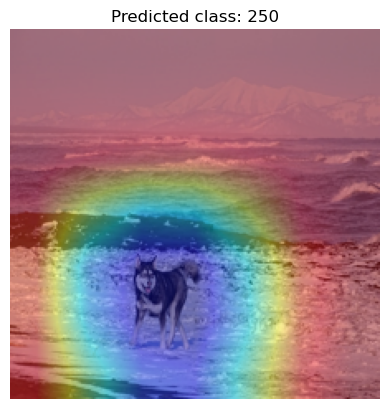

In [14]:
# Function to overlay CAM on original image
def show_cam_on_image(original_img, cam, title="CAM"):
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    img_np = np.array(original_img.resize((224, 224)))
    overlay = heatmap * 0.4 + img_np * 0.6
    plt.imshow(overlay.astype(np.uint8))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main CAM function
def cam_visualization(model, img_path):
    # Register hook to get final conv layer output
    layer_outputs = []
    hook = model.layer4.register_forward_hook(get_feature_hook(layer_outputs))

    # Preprocess and predict
    original_img, input_tensor = preprocess_image(img_path)
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

    # Get classifier weights
    fc_weights = model.fc.weight.detach()

    # Compute CAM
    features = layer_outputs[0]  # From hook
    cam = compute_cam(features, fc_weights, class_idx)

    # Show
    show_cam_on_image(original_img, cam, title=f"Predicted class: {class_idx}")

    # Clean up
    hook.remove()

# Example usage
cam_visualization(model, "image.jpg")  # Replace with your image path

<a name="references"></a>
## <b> <font color='red'> References </font> </b>

[TensorFlow: Advanced Techniques Specialization](https://www.coursera.org/specializations/tensorflow-advanced-techniques)